# My new code

In [1]:
import pdb
import sys, os
import sys; sys.path.append("../../..")  # Allows access to all the scripts/modules in the larger directory
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import time
import glob
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.axisartist.axislines import AxesZero
import matplotlib.gridspec as gridspec

from dca.methods_comparison import JPCA
#from pyuoi.linear_model.var  import VAR
from neurosim.models.var import form_companion

from utils import apply_df_filters, calc_loadings, calc_cascaded_loadings
from loaders import load_sabes
from decoders import lr_decoder
from segmentation import reach_segment_sabes, measure_straight_dev

## Import Data

In [2]:
################################ Decoding comparison #####################################

# Import marginals
with open('/home/marcush/Data/TsaoLabData/neural_control_output_new/decoding_deg_marginals_230322_214006_Jamie/decoding_deg_marginals_230322_214006_Jamie_glom.pickle', 'rb') as f:
    rl = pickle.load(f)
tsao_marginal_df = pd.DataFrame(rl)

# Import actual data
with open('/home/marcush/Data/TsaoLabData/neural_control_output_new/decoding_deg_230322_214006_Jamie/decoding_deg_230322_214006_Jamie_glom.pickle', 'rb') as f:
    rl = pickle.load(f)
tsao_df = pd.DataFrame(rl)

## Code to find average decoding differences over marginals

In [3]:
region = 'AM'


fold_idcs = np.unique(tsao_df['fold_idx'].values)
data_files = np.unique(tsao_df['data_file'].values)
dims = np.unique(tsao_df['dim'].values)
methods = np.unique(tsao_df['dimreduc_method'].values)

decoding_structs_FFC = np.zeros((data_files.size, fold_idcs.size, dims.size))
decoding_structs_FBC = np.zeros((data_files.size, fold_idcs.size, dims.size))

decoding_structs_marginal_FFC = np.zeros((data_files.size, fold_idcs.size, dims.size))
decoding_structs_marginal_FBC = np.zeros((data_files.size, fold_idcs.size, dims.size))


for df_ind, data_file in tqdm(enumerate(data_files)):
    for fold_ind, fold in enumerate(fold_idcs):
        
        tsao_pca_dim_sort = np.argsort(apply_df_filters(tsao_df, data_file=data_file, dimreduc_method='PCA', loader_args={'region': region},  fold_idx=fold)['dim'].values)
        decoding_structs_FFC[df_ind, fold_ind, :] = 1 - apply_df_filters(tsao_df, data_file=data_file, dimreduc_method='PCA', loader_args={'region': region},  fold_idx=fold)['loss'].values[tsao_pca_dim_sort]
        
        tsao_fcca_dim_sort = np.argsort(apply_df_filters(tsao_df, data_file=data_file, dimreduc_method='LQGCA', loader_args={'region': region},  fold_idx=fold)['dim'].values)
        decoding_structs_FBC[df_ind, fold_ind, :] = 1 - apply_df_filters(tsao_df, data_file=data_file, dimreduc_method='LQGCA', loader_args={'region': region},  fold_idx=fold)['loss'].values[tsao_fcca_dim_sort]
        
        tsao_pca_marg_dim_sort = np.argsort(apply_df_filters(tsao_marginal_df, data_file=data_file, dimreduc_method='PCA', loader_args={'region': region},  fold_idx=fold)['dim'].values)
        decoding_structs_marginal_FFC[df_ind, fold_ind, :] = 1 - apply_df_filters(tsao_marginal_df, data_file=data_file, dimreduc_method='PCA', loader_args={'region': region},  fold_idx=fold)['loss'].values[tsao_pca_marg_dim_sort]
        
        tsao_fcca_marg_dim_sort = np.argsort(apply_df_filters(tsao_marginal_df, data_file=data_file, dimreduc_method='LQGCA', loader_args={'region': region},  fold_idx=fold)['dim'].values)
        decoding_structs_marginal_FBC[df_ind, fold_ind, :] = 1 - apply_df_filters(tsao_marginal_df, data_file=data_file, dimreduc_method='LQGCA', loader_args={'region': region},  fold_idx=fold)['loss'].values[tsao_fcca_marg_dim_sort]


# Average across folds and plot
pca_dec = np.mean(decoding_structs_FFC, axis=1).squeeze()
fcca_dec = np.mean(decoding_structs_FBC, axis=1).squeeze()

pca_marginal_dec = np.mean(decoding_structs_marginal_FFC, axis=1).squeeze()
fcca_marginal_dec = np.mean(decoding_structs_marginal_FBC, axis=1).squeeze()

pca_dec = pca_dec.reshape(data_files.size, -1)
fcca_dec = fcca_dec.reshape(data_files.size, -1)
pca_marginal_dec = pca_marginal_dec.reshape(data_files.size, -1)
fcca_marginal_dec = fcca_marginal_dec.reshape(data_files.size, -1)


fcca_delta_marg = fcca_dec - fcca_marginal_dec
pca_delta_marg = pca_dec - pca_marginal_dec 

1it [00:00, 15.34it/s]


## Code to find average subspace angles over marginals

### I am here removing a number of assert lines to enforce shape specs (useful for other users)
### Assitionally, I only have one dimreduc type per file. One could imagine running with all parameters and doing selection like this, rather than my rather heuristic style of trying one set of dimreduc params per run

In [4]:
region = 'AM'
compare_dim = 21


fold_idcs = np.unique(tsao_df['fold_idx'].values)
data_files = np.unique(tsao_df['data_file'].values)
dims = np.unique(tsao_df['dim'].values)
dimreduc_methods = np.unique(tsao_df['dimreduc_method'].values)

#LQGCA_dimreduc_args = [{'T':3, 'loss_type':'trace', 'n_init':10}]

ss_angles = np.zeros((data_files.size, fold_idcs.size, 4, compare_dim))
# There should be another dim here, likely for the size of the output matrix

for df_ind, data_file in tqdm(enumerate(data_files)):
    for fold_ind, fold in enumerate(fold_idcs):

        dfpca = apply_df_filters(tsao_df, data_file=data_file, dimreduc_method='PCA', loader_args={'region': region}, fold_idx=fold, dim=compare_dim)
        dffcca = apply_df_filters(tsao_df, data_file=data_file, dimreduc_method='LQGCA', loader_args={'region': region}, fold_idx=fold, dim=compare_dim)

        dfpca_marginal = apply_df_filters(tsao_marginal_df, data_file=data_file, dimreduc_method='PCA', fold_idx=fold, dim=compare_dim)
        dffca_marginal = apply_df_filters(tsao_marginal_df, data_file=data_file, dimreduc_method='LQGCA', fold_idx=fold, dim=compare_dim)


        ss_angles[df_ind, fold_ind, 0, :] = scipy.linalg.subspace_angles(dfpca.iloc[0]['coef'][:, 0:compare_dim], dffcca.iloc[0]['coef'])
        ss_angles[df_ind, fold_ind, 1, :] = scipy.linalg.subspace_angles(dfpca.iloc[0]['coef'][:, 0:compare_dim], dfpca_marginal.iloc[0]['coef'][:, 0:compare_dim])
        ss_angles[df_ind, fold_ind, 2, :] = scipy.linalg.subspace_angles(dffcca.iloc[0]['coef'], dffca_marginal.iloc[0]['coef'])
        ss_angles[df_ind, fold_ind, 3, :] = scipy.linalg.subspace_angles(dffca_marginal.iloc[0]['coef'], dfpca_marginal.iloc[0]['coef'][:, 0:compare_dim])

stat, p = scipy.stats.wilcoxon(np.mean(ss_angles[:, :, 2, :], axis=-1).ravel(), np.mean(ss_angles[:, :, 1, :], axis=-1).ravel(), alternative='greater')
print(p)
print('\n')

stat, p = scipy.stats.wilcoxon(np.mean(ss_angles[:, :, 2, :], axis=-1).ravel(), np.mean(ss_angles[:, :, 0, :], axis=-1).ravel(), alternative='greater')
print(p)
print('\n')

1it [00:00, 19.98it/s]

0.03125


0.03125




## Plot Code

Delta decoding p=0.500000
0.08238435284190376


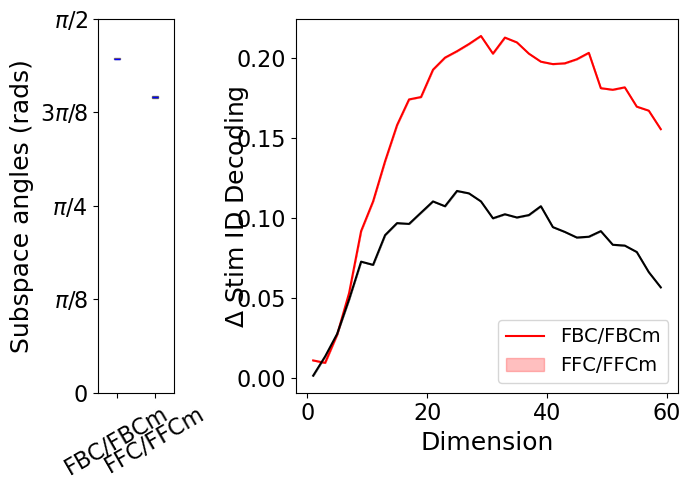

In [5]:
fig = plt.figure(figsize=(7, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax = [ax0, ax1]


############################ Ax 0: Subspace angles over Marginals ############################

medianprops = dict(linewidth=1, color='b')
whiskerprops = dict(linewidth=0)
bplot = ax[0].boxplot([np.mean(ss_angles[:, :, 2, :], axis=-1).ravel(), np.mean(ss_angles[:, :, 1, :], axis=-1).ravel()], 
                patch_artist=True, medianprops=medianprops, notch=False, showfliers=False,
                whiskerprops=whiskerprops, showcaps=False)
ax[0].set_xticklabels(['FBC/FBCm', 'FFC/FFCm'], rotation=30)
for label in ax[0].get_xticklabels():
    label.set_horizontalalignment('center')
ax[0].set_ylim([0, np.pi/2])
ax[0].set_yticks([0, np.pi/8, np.pi/4, 3 * np.pi/8, np.pi/2])
ax[0].set_yticklabels(['0', r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'])
ax[0].tick_params(axis='both', labelsize=16)
ax[0].set_ylabel('Subspace angles (rads)', fontsize=18)
colors = ['r', 'k']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)


############################ Ax 1: Decoding over Marginals ############################
sqrt_norm_val = 28

colors = ['black', 'red', '#781820', '#5563fa']

# FCCA Decoding Over Marginals
ax[1].plot(dims, np.mean(fcca_delta_marg, axis=0), color=colors[1])
ax[1].fill_between(dims, np.mean(fcca_delta_marg, axis=0) + np.std(fcca_delta_marg, axis=0)/np.sqrt(sqrt_norm_val),
                np.mean(fcca_delta_marg, axis=0) - np.std(fcca_delta_marg, axis=0)/np.sqrt(sqrt_norm_val), color=colors[1], alpha=0.25)

# PCA Decoding Over Marginals
ax[1].plot(dims, np.mean(pca_delta_marg, axis=0), color=colors[0])
ax[1].fill_between(dims, np.mean(pca_delta_marg, axis=0) + np.std(pca_delta_marg, axis=0)/np.sqrt(sqrt_norm_val),
                np.mean(pca_delta_marg, axis=0) - np.std(pca_delta_marg, axis=0)/np.sqrt(sqrt_norm_val), color=colors[0], alpha=0.25)



ax[1].set_xlabel('Dimension', fontsize=18)
ax[1].set_ylabel(r'$\Delta$' + ' Stim ID Decoding ', fontsize=18, labelpad=-10)
ax[1].tick_params(axis='x', labelsize=16)
ax[1].tick_params(axis='y', labelsize=16)
#ax[1].set_ylim([0, 0.2])
#ax[1].set_yticks([0, 0.2])
ax[1].legend(['FBC/FBCm', 'FFC/FFCm'], loc='lower right', fontsize=14)


# Some Statistical Tests
comp_dim = 21
comp_dim_ind = np.argwhere(dims == comp_dim)[0][0]
stat, p = scipy.stats.wilcoxon(fcca_delta_marg[:, comp_dim_ind], pca_delta_marg[:, comp_dim_ind], alternative='greater')
print('Delta decoding p=%f' % p)
print(np.mean(fcca_delta_marg[:, comp_dim_ind]) - np.mean(pca_delta_marg[:, comp_dim_ind]))

fig.tight_layout()
#fig.savefig('%s/decoding_differences.pdf' % figpath, bbox_inches='tight', pad_inches=0)

